In [3]:
%matplotlib inline
import sys
import spotipy
import spotipy.util as util
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
from spotipy.oauth2 import SpotifyClientCredentials

In [4]:
client_credentials_manager = SpotifyClientCredentials('40cd9cd27c7c4689bc36774f5aac188b','10d3a4b01aea4976ac89c831db901a6d')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [5]:
def show_tracks(results):
    for i, item in enumerate(results['items']):
        track = item['track']
        print("   %d %32.32s %s" % (i, track['artists'][0]['name'], track['name']))

In [6]:
def trackdeets(username, playid):
    playlist1 = sp.user_playlist(username,playid)
    tracks=playlist1['tracks']
    playtracs={}
    for i, item in enumerate(tracks['items']):
        track = item['track']
        playtracs[track['id']]=track['name']
        while tracks['next']:
            tracks = sp.next(tracks)
            for i, item in enumerate(tracks['items']):
                track = item['track']
                playtracs[track['id']]=track['name']

    return playtracs

In [7]:
def sametraclist(playlist1,playlist2):
    sametracs = playlist1.items() & playlist2.items()
    sametracs = dict(sametracs)
    playlist1 = dict(playlist1.items() - sametracs.items())
    playlist2 = dict(playlist2.items() - sametracs.items())
    playlist1 = {k:v.split("-")[0] for (k,v) in  playlist1.items()}
    playlist2 = {k:v.split("-")[0] for (k,v) in  playlist2.items()}
    sametracs1 ={k: v for (k,v) in playlist1.items() if v in list(playlist2.values()) }
    sametracs.update(sametracs1)
    return sametracs 

In [8]:
def artistdeets(username, playid):
    playlist1 = sp.user_playlist(username,playid)
    tracks=playlist1['tracks']
    playtracs={}
    for i, item in enumerate(tracks['items']):
        track = item['track']
        if track['artists'][0]['id'] in playtracs:
            playtracs[track['artists'][0]['id']].append(track['id'])
        else:
            playtracs[track['artists'][0]['id']]=[track['id']]
        while tracks['next']:

            tracks = sp.next(tracks)
            for i, item in enumerate(tracks['items']):
                track = item['track']
                if track['artists'][0]['id'] in playtracs:
                    playtracs[track['artists'][0]['id']].append(track['id'])
                else:
                    playtracs[track['artists'][0]['id']]=[track['id']]

    return playtracs

In [9]:
def sameartists(playlist1,playlist2):
    artistlist = [play1artists.keys() & play2artists.keys()]
    sameartists = {}
    for k in artistlist[0]:
        sameartists[k] = [play1artists[k],play2artists[k]]
        
    return sameartists

In [10]:
def audiofeats(playlist):
    audiodeets=[]
    trackids = list(playlist.keys())
    if len(trackids) <= 50:
        audiodeets = sp.audio_features(trackids)
    else:  
        for i in range(0,(int(len(trackids)/50)+1)):
            audiodeets.extend(sp.audio_features(trackids[i*50:(i+1)*50]))
    audiodeets = list(filter(None,audiodeets)) 
    audiodeets=pd.DataFrame(audiodeets)
    audiodeets.index = audiodeets['id']
    audiodeets = audiodeets.drop(['analysis_url','track_href','type','uri','id'],axis=1)
    return audiodeets

In [11]:
play1tracs=trackdeets('hmanasa95','490oPD2OlU69R7bM4SyGHz')
play2tracs=trackdeets('spotify','37i9dQZF1DWTJ7xPn4vNaz')
play3tracs=trackdeets('spotify','37i9dQZF1DX0XUsuxWHRQd')
play4tracs=trackdeets('spotify','37i9dQZF1DWWGFQLoP9qlv')


In [12]:
play1artists=artistdeets('hmanasa95', '490oPD2OlU69R7bM4SyGHz')
play2artists=artistdeets('spotify','37i9dQZF1DWTJ7xPn4vNaz')

In [13]:
len(play3tracs)

50

In [14]:
audio2deets = audiofeats(play2tracs)
audio3deets = audiofeats(play3tracs)
audio4deets = audiofeats(play4tracs)
audio3deets['playno'] = 1
audio4deets['playno'] = 2
playnames = list(play2tracs.values())
playnames.extend(list(play4tracs.values()))
temp = pd.concat([audio2deets,audio4deets])

In [15]:
len(playnames)

195

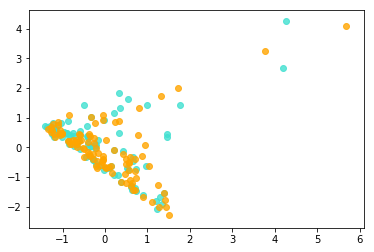

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
x = StandardScaler().fit_transform(temp[['acousticness', 'danceability','energy','liveness','mode','speechiness','valence']])
pca = decomposition.PCA(n_components=3)
songpca = pca.fit_transform(x)
plt.scatter(songpca[0:89, 0], songpca[0:89, 1], color='turquoise', alpha=.8)
plt.scatter(songpca[90:189, 0], songpca[90:189, 1], color='orange', alpha=.8)


In [36]:
import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go

In [37]:
trace1 = go.Scatter3d(
    x=songpca[0:89, 0],
    y=songpca[0:89, 1],
    z=songpca[0:89, 2],
    mode='markers',
    text = playnames[0:89],
    hoverinfo = 'text',
    name = "playlist1",
    marker=dict(
        size=7,
        color = 'red',
        opacity=0.8
    )
)
trace2 = go.Scatter3d(
    x=songpca[90:189, 0],
    y=songpca[90:189, 1],
    z=songpca[90:189, 2],
    name = "playlist2",
    text = playnames[90:189],
    hoverinfo = 'text',
    mode='markers',
    marker=dict(
        size=7,
        color = 'blue',
        opacity=0.8
    )
)
data = [trace1, trace2]
layout = go.Layout(
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~rijn/0 or inside your plot.ly account where it is named 'simple-3d-scatter'


In [25]:
trace1 = go.Scatter3d(
    x=x[0:49, 0],
    y=x[0:49, 1],
    z=x[0:49, 2],
    mode='markers',
    text = playnames[0:49],
    hoverinfo = 'text',
    name = "playlist1",
    marker=dict(
        size=7,
        color = 'red',
        opacity=0.8
    )
)
trace2 = go.Scatter3d(
    x=x[50:149, 0],
    y=x[50:149, 1],
    z=x[50:149, 2],
    name = "playlist2",
    text = playnames[50:149],
    hoverinfo = 'text',
    mode='markers',
    marker=dict(
        size=7,
        color = 'blue',
        opacity=0.8
    )
)
data = [trace1, trace2]
layout = go.Layout(
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~rijn/0 or inside your plot.ly account where it is named 'simple-3d-scatter'


In [243]:
plotly.tools.set_credentials_file(username='manasah', api_key='lwaibUKBBBO66a45N6VY')

In [ ]:
lwaibUKBBBO66a45N6VY